In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as spi
from IPython.display import Image
from matplotlib import rcParams
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 26
rcParams['legend.fontsize']= 'x-large'
rcParams['axes.titlesize']= 'x-large'
rcParams['xtick.labelsize']= 'x-large'
rcParams['ytick.labelsize']= 'x-large'
rcParams['axes.labelsize']= 'x-large'
rcParams['figure.titlesize']= 'xx-large'
%matplotlib inline
#rcParams.keys()

# Problema de Introducción.

Veamos un pequeño problema de modelamiento matemático como motivación a estudiar lo siguiente.

Este gráfico ilustra la evolución de la temperatura global en superficie con respecto a las temperaturas medias de 1951-1980. Diecinueve de los años más calurosos se han producido desde 2000, con la excepción de 1998. El año 2020 empató con 2016 como el año más caluroso registrado desde que se empezaron a llevar registros en 1880 (fuente: NASA/GISS). Esta investigación coincide en líneas generales con construcciones similares elaboradas por la Unidad de Investigación Climática y la Administración Nacional Oceánica y Atmosférica. La serie temporal que aparece a continuación muestra la variación media de cinco años de las temperaturas superficiales globales. El azul oscuro indica las zonas más frías que la media. El rojo oscuro indica las zonas más cálidas que la media.

La cifra de "Temperatura Global" en el tablero de la página principal muestra el cambio de la temperatura global desde 1880. Se obtiene esta cifra restando el primer punto de datos del gráfico del último punto de datos.

<img width="99%" src="../figures/global_temp_nasa_noaa.png"/> 

In [9]:
temp_data=pd.read_csv("../datas/global_temp_nasa_noaa.txt",delimiter="\s+",skiprows=2,header=0)
temp_data.head()

,Year,No_Smoothing,Lowess(5)
0,1880,-0.16,-0.09
1,1881,-0.08,-0.12
2,1882,-0.10,-0.16
3,1883,-0.17,-0.20
4,1884,-0.28,-0.23


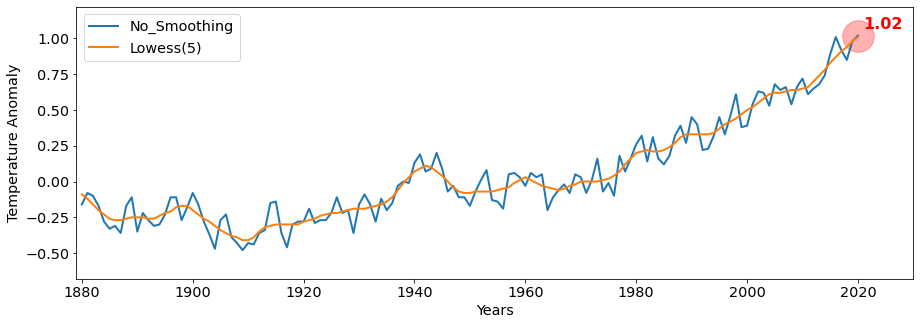

In [40]:
plt.figure(figsize=(15,5))
plt.plot(temp_data["Year"],temp_data["No_Smoothing"],label="No_Smoothing")
plt.plot(temp_data["Year"],temp_data["Lowess(5)"],label="Lowess(5)")
plt.xlabel("Years")
plt.ylabel("Temperature Anomaly")
plt.text(temp_data["Year"].iloc[-1]+1,temp_data["No_Smoothing"].iloc[-1]+0.05,str(temp_data["No_Smoothing"].iloc[-1]),fontsize=16,color="red",weight="bold")
plt.axis([temp_data["Year"].min()-1,temp_data["Year"].max()+10,temp_data["No_Smoothing"].min()-0.2,temp_data["No_Smoothing"].max()+0.2])
plt.scatter(temp_data["Year"].iloc[-1],temp_data["No_Smoothing"].iloc[-1],s=1000,alpha=0.3,color="red")
plt.legend()
plt.show()

# Diferenciación Numérica en Python

## Enunciado del problema de diferenciación numérica

Una malla numérica es un conjunto de puntos espaciados uniformemente sobre el dominio de una función (es decir, la variable independiente), en algún intervalo. El espaciamiento o tamaño de paso de una cuadrícula numérica es la distancia entre puntos adyacentes en la cuadrícula. Si $x$ es una malla numérica, $x_j$ es el punto $j$ de la malla numérica y $h$ es el espaciado entre $x_{j-1}$ y $x_j$. La siguiente figura muestra un ejemplo de cuadrícula numérica.

<img width="40%" src="../figures/Numerical_grid.png">

Existen varias funciones en Python que pueden utilizarse para generar mallas numéricas. Para las rejillas numéricas en una dimensión, basta con utilizar la función linspace, que ya ha utilizado para crear matrices regularmente espaciadas.

En Python, una función $f(x)$ puede representarse en un intervalo calculando su valor en una cuadrícula. Aunque la función en sí puede ser continua, esta representación discreta o discretizada es útil para los cálculos numéricos y se corresponde con los conjuntos de datos que pueden adquirirse en la práctica de la ingeniería y la ciencia. En concreto, el valor de la función puede conocerse sólo en puntos discretos. Por ejemplo, un sensor de temperatura puede entregar pares de temperatura versus tiempo en intervalos de tiempo regulares. Aunque la temperatura es una función suave y continua del tiempo, el sensor sólo proporciona valores en intervalos de tiempo discretos, y en este caso particular, la función subyacente ni siquiera se conocería.

Tanto si $f$ es una función analítica o una representación discreta de una, nos gustaría derivar métodos de aproximación de la derivada de $f$ sobre una malla numérica y determinar su precisión.
